In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/samples.csv')
df.head()

,Unnamed: 0,a,b,c,d
0,1/1/1950,36,27,0,67
1,2/1/1950,58,22,3,31
2,3/1/1950,61,17,5,67
3,4/1/1950,37,15,8,47
4,5/1/1950,66,13,8,62


# Stationarity
Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>
The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

<AxesSubplot:title={'center':'STATIONARY DATA'}>

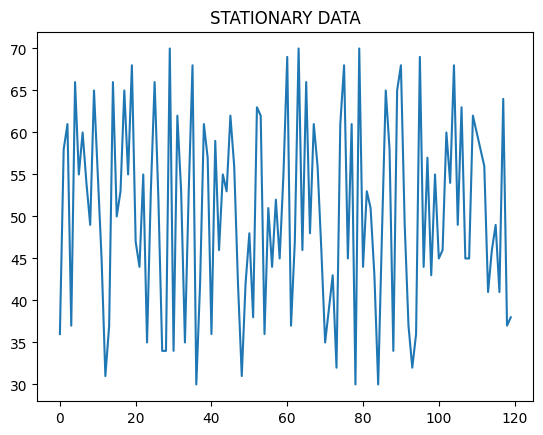

In [3]:
df.a.plot(title='STATIONARY DATA')

<AxesSubplot:title={'center':'NON STATIONARY DATA'}>

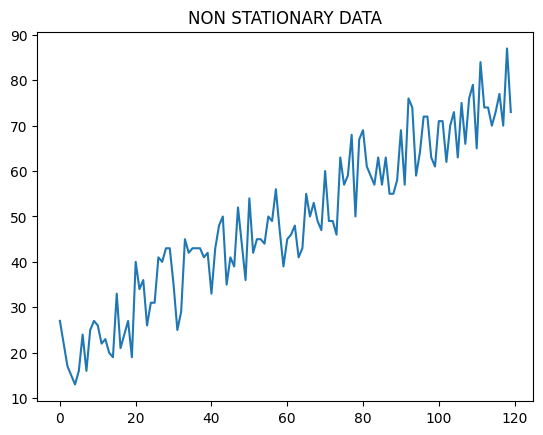

In [4]:
df.b.plot(title='NON STATIONARY DATA')

In [2]:
# load a seasonal dataset
df1 = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)
df1.index.freq = 'MS'

# load a nonseasonal dataset
df2 = pd.read_csv('data/DailyTotalFemaleBirths.csv', index_col='Date', parse_dates=True)
df2.index.freq = 'D'

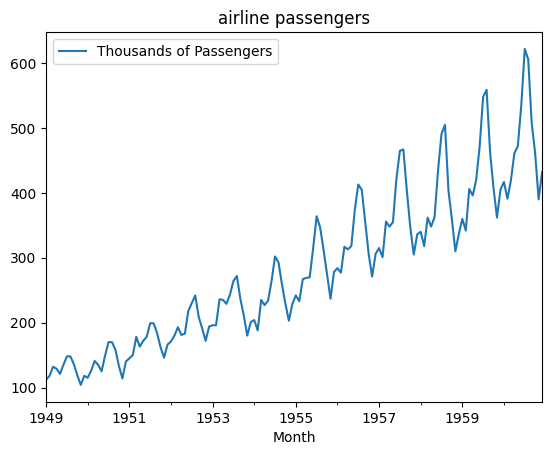

In [7]:
df1.plot(title='airline passengers');

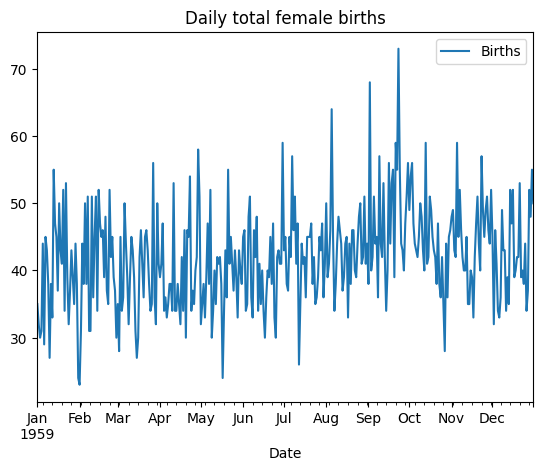

In [8]:
df2.plot(title='Daily total female births');

# Tests for Stationarity
A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests. 

## Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

In [5]:
from statsmodels.tsa.stattools import adfuller

In [11]:
dftest = adfuller(df1['Thousands of Passengers'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations'])
for key, val in dftest[4].items():
    dfout[f'critical value ({key})'] = val
print(dfout.to_string())

ADF Test Statistic        0.815369
p-value                   0.991880
# Lags Used              13.000000
# Observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770


Here we have a very high p-value at 0.99, which provides weak evidence against the null hypothesis, and so we <em>fail to reject</em> the null hypothesis, and decide that our dataset is not stationary.<br>
Note: in statistics we don't "accept" a null hypothesis - nothing is ever truly proven - we just fail to reject it.

### Function for running the augmented Dickey-Fuller test

In [3]:
# compare Test Statistic and Critical Values: should be in similar ranges
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

Augmented Dickey-Fuller Test: airline_passengers
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

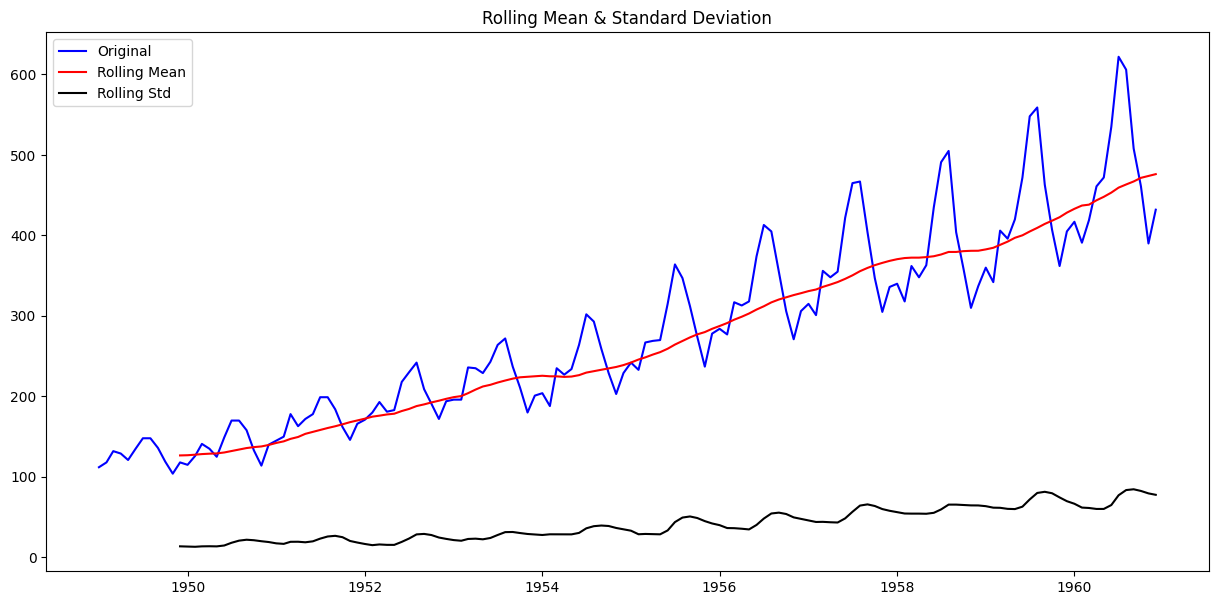

In [6]:
adf_test(df1['Thousands of Passengers'], 'airline_passengers')

# Determing rolling statistics
rolmean = df1['Thousands of Passengers'].rolling(12).mean()
rolstd = df1['Thousands of Passengers'].rolling(12).std()

# Plot rolling statistics:
plt.figure(figsize=(15,7))
plt.plot(df1['Thousands of Passengers'], color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [13]:
adf_test(df2['Births'], 'DailyTotalFemaleBirths')

Augmented Dickey-Fuller Test: DailyTotalFemaleBirths
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


here test statistic value is smaller than 10%, 5% and 1% and hence we can say that there is 99% confidance that series is stationary series

# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
df3 = pd.read_csv('data/samples.csv', index_col=0, parse_dates=True)
df3.index.freq = 'MS'

<AxesSubplot:>

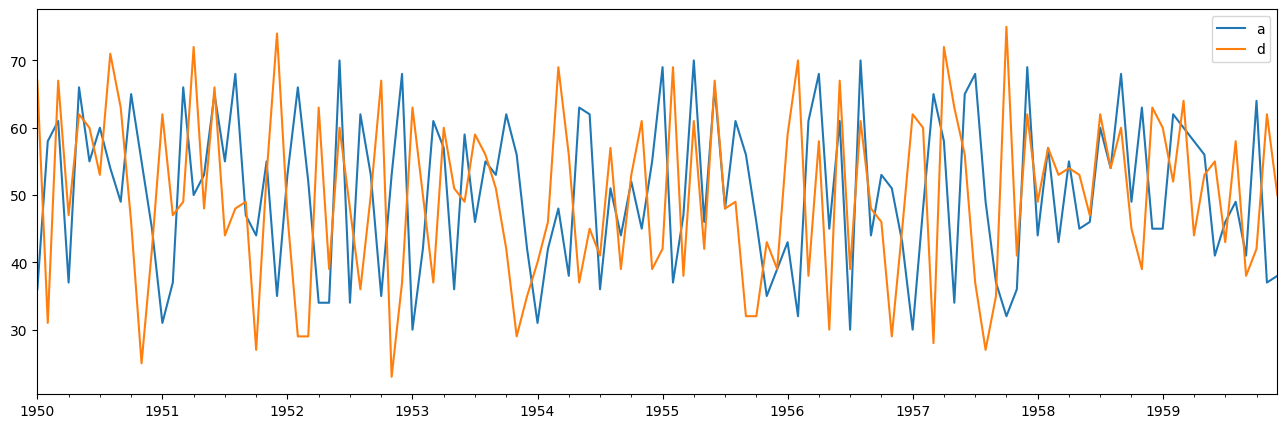

In [15]:
df3[['a', 'd']].plot(figsize=(16,5))

<AxesSubplot:>

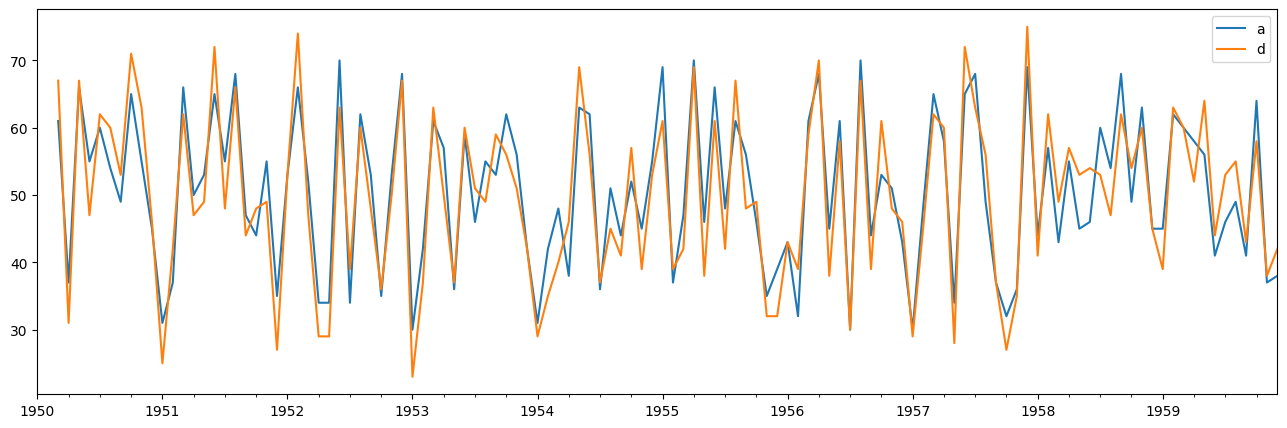

In [24]:
df3['a'].iloc[2:].plot(figsize=(16,5), legend=True)
df3['d'].shift(2).plot(legend=True)

In [18]:
grangercausalitytests(df3[['a','d']], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


Essentially we're looking for extremely low p-values, which we see at lag 2.

In [22]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

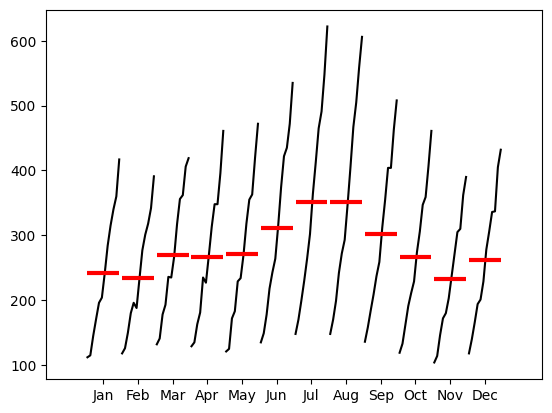

In [29]:
month_plot(df1['Thousands of Passengers']);

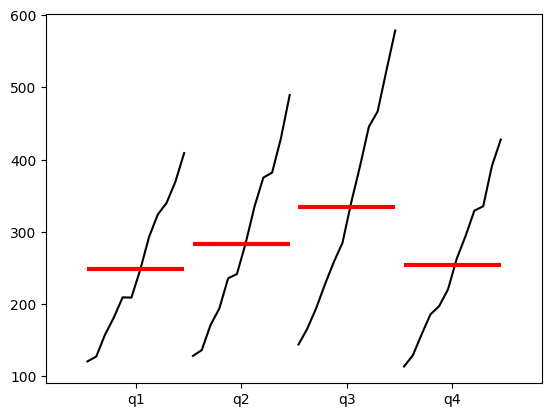

In [26]:
dfq = df1['Thousands of Passengers'].resample(rule='Q').mean()
quarter_plot(dfq);